In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

train = pd.read_csv("output/sorted_train0310.csv")
test = pd.read_csv("output/sorted_test0310.csv")
val = pd.read_csv("output/sorted_val0310.csv")

In [50]:
# Define function to calculate the relative time to a default
from datetime import datetime

def calculate_days_to_default(approval, chargeoff, terms):
    # No default occurred, return TermInMonths in days
    if pd.isnull(chargeoff):
        return terms / 12 * 365
    
    d1 = datetime.strptime(approval.split()[0], "%Y-%m-%d")
    d2 = datetime.strptime(chargeoff.split()[0], "%Y-%m-%d")
    return (d2 - d1).days

def add_relative_time_col(df):
    DaysToDefault = []
    for index, row in df.iterrows():
        approval = row["ApprovalDate"]
        chargeoff = row["ChargeOffDate"]
        terms = row['TermInMonths']
        DaysToDefault.append(calculate_days_to_default(approval, chargeoff, terms))

    df['DaysToDefault'] = pd.Series(DaysToDefault).values

    # Remove ApprovalDate, ChargeOffDate -- we no longer need these columns
#     df = df.drop(columns=["ApprovalDate", "ChargeOffDate"])

    # Convert True/False to 0/1s for Default? column
    df['Default?'] = df['LoanStatus']=='CHGOFF'
    df['Default?'] = df['Default?'].astype(int)
    return df

In [51]:
train = add_relative_time_col(train)
# train.columns.tolist()

val = add_relative_time_col(val)
# val.columns.tolist()
test = add_relative_time_col(test)

In [52]:
# filtering for the columns you don't want to include for your model
c = train.columns.tolist()
c.remove('LoanStatus')
c.remove('ChargeOffDate')
c.remove('GrossChargeOffAmount')
c.remove('BorrZip')
c.remove('CDC_Zip')
c.remove('BorrCity')

c.remove('BorrState')
c.remove('CDC_State')
c.remove('ThirdPartyLender_State')
c.remove('ProjectState')

c.remove('CDC_City')
c.remove('ProjectCounty')
c.remove('ThirdPartyLender_City')
c.remove('ApprovalDate')
# c.remove('DaysToDefault')
# c.remove('Default?')
print c

['ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Log_GrossApproval_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']


In [53]:
x_train = train[c]
x_train = pd.get_dummies(x_train)
print x_train.shape
x_val = val[c]
x_val = pd.get_dummies(x_val)
print x_val.shape
x_test = test[c]
x_test = pd.get_dummies(x_test)
print x_test.shape

(43845, 48)
(5481, 47)
(5481, 25)


In [54]:
# hazard rate model on all loan samples
from lifelines import CoxPHFitter
cph1 = CoxPHFitter()
cph1.fit(x_train, duration_col='DaysToDefault', event_col='Default?')

<lifelines.CoxPHFitter: fitted with 43845 observations, 38509 censored>

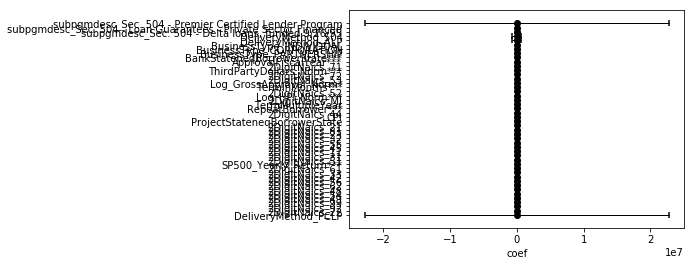

In [55]:
cph1.plot()

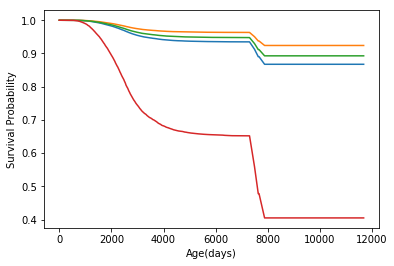

In [137]:
p = cph1.predict_survival_function(x_train[10:14].drop(['DaysToDefault','Default?'], axis = 1))
plt.xlabel('Age(days)')
plt.ylabel('Survival Probability')
plt.plot(p)

In [57]:
cph1.print_summary()

n=43845, number of events=5336

                                                         coef  exp(coef)      se(coef)       z      p     lower 0.95    upper 0.95     
ApprovalFiscalYear                                     0.2286     1.2569        0.0120 19.0820 0.0000         0.2051        0.2521  ***
TermInMonths                                          -0.0028     0.9972        0.0005 -5.3293 0.0000        -0.0038       -0.0018  ***
SP500_Yearly_Return                                   -0.6363     0.5293        0.1071 -5.9395 0.0000        -0.8462       -0.4263  ***
CPI                                                   -0.2779     0.7574        0.4902 -0.5668 0.5708        -1.2386        0.6829     
Log_GrossApproval_Norm                                 0.0309     1.0313        0.0153  2.0174 0.0437         0.0009        0.0608    *
Log_HPI_Norm                                          -0.1281     0.8797        0.0198 -6.4588 0.0000        -0.1670       -0.0892  ***
ThirdPartyDollar

      ApprovalFiscalYear  TermInMonths  SP500_Yearly_Return       CPI  \
coef            0.228611     -0.002799            -0.636254 -0.277854   

      Log_GrossApproval_Norm  Log_HPI_Norm  ThirdPartyDollars_Norm  \
coef                0.030854     -0.128126                 0.09092   

      TermMultipleYear  RepeatBorrower  BankStateneqBorrowerState  \
coef         -0.177005       -0.218619                   0.307274   

           ...        2DigitNaics_55  2DigitNaics_56  2DigitNaics_61  \
coef       ...             -0.467073       -0.828726       -0.640733   

      2DigitNaics_62  2DigitNaics_71  2DigitNaics_72  2DigitNaics_81  \
coef       -0.877679        0.105422        0.048507       -0.355691   

      2DigitNaics_92  2DigitNaics_99  2DigitNaics_MI  
coef        -1.62019       -1.600649       -0.173745  

[1 rows x 46 columns]
-54219.1465634


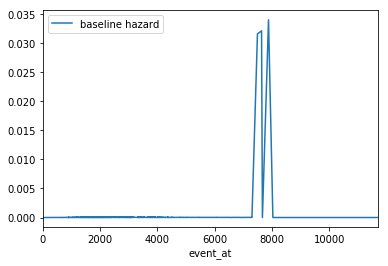

In [59]:
print cph1.hazards_

print cph1._log_likelihood

# cph1._hessian_

# cph1._score_

cph1.baseline_hazard_.plot()

In [69]:
# call this if want to test accuracy on val and test dataset

# to get consistent feature dimensions for both train and test dataset
def add_missing_dummy_columns(d1, d2):
    missing_cols = set(d1.columns) - set(d2.columns)
    for c in missing_cols:
        d2[c] = 0
    return d2

print 'before fix columns: '
print x_train.shape
print x_test.shape

def fix_columns(x_train, x_test):  

    x_test = add_missing_dummy_columns(x_train, x_test)

    extra_cols = set(x_test.columns) - set(x_train.columns)
    x_test = x_test[x_train.columns]
    return x_test

x_test = fix_columns(x_train, x_test)
x_val = fix_columns(x_train, x_val)
print 'after fix columns: '
print x_test.shape
print x_val.shape

before fix columns: 
(43845, 48)
(5481, 25)
after fix columns: 
(5481, 48)
(5481, 48)


In [133]:
# predicting defaults using ROC curves and AUC
# y axis = true positive rate = recall = sensitivity = 
# measures the proportion of positives that are correctly identified as such
# true positive rate = # of defaults predicted that are actually defaults(TPs) / total number of defaults
# x axis = false positive rate = # of false positives / total number of negatives = 
# FPR = # of falsely predicted defaults(PIF that are predicted to be defaults) / total number of PIFs
# let thre be the thre of predicting defaults, since hazard model gives prob of survival, 1-score is the prob of default
from sklearn import metrics

def get_roc(scores, labels):
    num_defaults = sum(labels)
    num_PIF = len(labels) - num_defaults
    tpr_res = []
    fpr_res = []
    thre = np.arange(0, 1, 0.01)
    # dictionary with key = threshold and value = pair of (tpr, fpr)
    for t in thre:
        tp = fp = 0
        for idx, val in enumerate(scores):
            if 1 - val > t:
                # predict default
                if int(labels[idx]) == 1: 
                    tp += 1
                else:
                    fp += 1
        tpr = float(tp) / num_defaults
        fpr = float(fp) / num_PIF
        print 'score is', 
        print 'calculating fpr tpr for threshold: ', t,'tpr is: ', tpr, 'fpr is', fpr
        print 'tp is ', tp, 'fp is', fp 
        tpr_res.append(tpr)
        fpr_res.append(fpr)
    roc_auc = metrics.auc(fpr_res, tpr_res)
    print 'calculating auc is: ', roc_auc
    return tpr_res, fpr_res, thre, roc_auc

import matplotlib.pyplot as plt

def plot_roc(tpr, fpr, thre, roc_auc):
    plt.title('Receiver Operating Characteristics')
    plt.plot(tpr, fpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend()
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()


In [169]:
# calculates predicted survival probability of given X's at its terminmonths age.
# after fitting the cph hazard model on x_train
# call get_score(x_train, cph), which calculates survival probability of each sample in x at the end of its age
# once obtained survival probability - can call get_roc curve

def search(days, dist, thre):
    # find the prob that corresponds to the days
    if days > dist[-1][0]: 
        return dist[-1][1]
    l = 0
    r = len(dist)-1
    while l < r and r > 0 and l < len(dist)-1:
        mid = l + (r - l)/2
        if abs(int(dist[mid][0]) - days) < thre:
            return dist[mid][1]
        elif int(dist[mid][0]) < days:
            l = mid + 1
        else:
            r = mid - 1

def get_scores(x_train, cph):
    scores = []

    for i in range(len(x_train) - 1):
        if i%1000 == 0: print 'finished getting scores for %d samples' % i
        i = 1
        days = x_train['TermInMonths'].loc[i] * 30
        t = cph.predict_survival_function(x_train[i:i+1].drop(['DaysToDefault','Default?'], axis = 1))
        idx = np.array(t.index.tolist())
        val = np.array(t.values.tolist())
        idx = np.reshape(idx, (len(idx), 1))
        dist = np.concatenate((idx, val), axis=1) # [days, prob]
        survival_prob = search(days, dist, 100)
        scores.append(survival_prob)

    return scores

finished getting scores for 0 samples
finished getting scores for 100 samples
finished getting scores for 200 samples
finished getting scores for 300 samples
finished getting scores for 400 samples
finished getting scores for 500 samples
finished getting scores for 600 samples
finished getting scores for 700 samples
finished getting scores for 800 samples
finished getting scores for 900 samples
finished getting scores for 1000 samples
finished getting scores for 1100 samples
finished getting scores for 1200 samples
finished getting scores for 1300 samples
finished getting scores for 1400 samples
finished getting scores for 1500 samples
finished getting scores for 1600 samples
finished getting scores for 1700 samples
finished getting scores for 1800 samples
finished getting scores for 1900 samples
finished getting scores for 2000 samples
finished getting scores for 2100 samples
finished getting scores for 2200 samples
finished getting scores for 2300 samples
finished getting scores for 

finished getting scores for 19800 samples
finished getting scores for 19900 samples
finished getting scores for 20000 samples
finished getting scores for 20100 samples
finished getting scores for 20200 samples
finished getting scores for 20300 samples
finished getting scores for 20400 samples
finished getting scores for 20500 samples
finished getting scores for 20600 samples
finished getting scores for 20700 samples
finished getting scores for 20800 samples
finished getting scores for 20900 samples
finished getting scores for 21000 samples
finished getting scores for 21100 samples
finished getting scores for 21200 samples
finished getting scores for 21300 samples
finished getting scores for 21400 samples
finished getting scores for 21500 samples
finished getting scores for 21600 samples
finished getting scores for 21700 samples
finished getting scores for 21800 samples
finished getting scores for 21900 samples
finished getting scores for 22000 samples
finished getting scores for 22100 

finished getting scores for 39400 samples
finished getting scores for 39500 samples
finished getting scores for 39600 samples
finished getting scores for 39700 samples
finished getting scores for 39800 samples
finished getting scores for 39900 samples
finished getting scores for 40000 samples
finished getting scores for 40100 samples
finished getting scores for 40200 samples
finished getting scores for 40300 samples
finished getting scores for 40400 samples
finished getting scores for 40500 samples
finished getting scores for 40600 samples
finished getting scores for 40700 samples
finished getting scores for 40800 samples
finished getting scores for 40900 samples
finished getting scores for 41000 samples
finished getting scores for 41100 samples
finished getting scores for 41200 samples
finished getting scores for 41300 samples
finished getting scores for 41400 samples
finished getting scores for 41500 samples
finished getting scores for 41600 samples
finished getting scores for 41700 

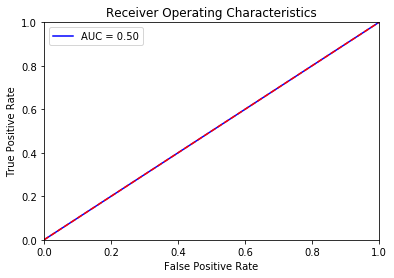

In [168]:
# scores = get_scores(x_train, cph1)
# print scores
tpr, fpr, thre, roc_auc = get_roc(scores, x_train['Default?'].values.tolist())
plot_roc(tpr, fpr, thre, roc_auc)

In [60]:
# hazard model only on data that is death event - only on the ones that are charged off
death = train[train['LoanStatus'] == 'CHGOFF']
death = death.reset_index(drop=True)
death['Duration'] = pd.to_datetime(death['ChargeOffDate']) - pd.to_datetime(death['ApprovalDate'])
death['Observed'] = 1
death = death[c]
death.head()

,ApprovalFiscalYear,DeliveryMethod,subpgmdesc,TermInMonths,BusinessType,SP500_Yearly_Return,CPI,Log_GrossApproval_Norm,Log_HPI_Norm,ThirdPartyDollars_Norm,TermMultipleYear,RepeatBorrower,BankStateneqBorrowerState,ProjectStateneqBorrowerState,2DigitNaics,DaysToDefault,Default?
0,2004,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.120274,0.969,0.335743,0.266927,0.480989,True,0,False,False,72,1537,1
1,2004,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.120274,0.969,1.421916,0.266927,-0.377884,True,0,False,False,71,2977,1
2,2005,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.065440,1.040,-1.477124,0.454916,-0.196954,True,0,False,False,54,1848,1
3,2006,ALP,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.155040,1.081,-0.180838,1.497527,0.170356,True,0,True,False,33,2711,1
4,1999,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,240,CORPORATION,0.305258,0.887,0.286921,-0.555141,-0.377884,True,0,False,False,MI,2909,1


In [176]:
sum(x_train['RepeatBorrower'])

2101

In [61]:
x_train_death = pd.get_dummies(death)

# hazard rate model on only charged off loan samples
cph2 = CoxPHFitter()
cph2.fit(x_train_death, duration_col='DaysToDefault', event_col='Default?', show_progress = True)

# cph.plot()

Iteration 1: norm_delta = 157.77832, step_size = 0.50000, ll = -40463.99782
Iteration 2: norm_delta = 3.25541, step_size = 0.24875, ll = -40084.81384
Iteration 3: norm_delta = 0.76328, step_size = 0.24751, ll = -40011.53709
Iteration 4: norm_delta = 2.58950, step_size = 0.24627, ll = -39966.49735
Iteration 5: norm_delta = 65.30596, step_size = 0.24504, ll = -39939.07973
Iteration 6: norm_delta = 0.32449, step_size = 0.12191, ll = -39922.55286
Iteration 7: norm_delta = 0.16359, step_size = 0.12130, ll = -39917.27834
Iteration 8: norm_delta = 0.40027, step_size = 0.12069, ll = -39913.15770
Iteration 9: norm_delta = 0.96543, step_size = 0.12009, ll = -39909.94018
Iteration 10: norm_delta = 15.85954, step_size = 0.11949, ll = -39907.42874
Iteration 11: norm_delta = 0.10396, step_size = 0.05944, ll = -39905.46880
Iteration 12: norm_delta = 0.78153, step_size = 0.05915, ll = -39904.68000
Iteration 13: norm_delta = 26.09403, step_size = 0.05885, ll = -39903.98232
Iteration 14: norm_delta = 0.

<lifelines.CoxPHFitter: fitted with 5336 observations, 0 censored>

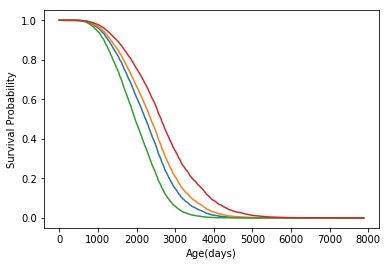

In [170]:
p2 = cph2.predict_survival_function(x_train_death[10:14].drop(['DaysToDefault','Default?'], axis = 1))
plt.xlabel('Age(days)')
plt.ylabel('Survival Probability')
plt.plot(p2)

In [63]:
cph2.print_summary()

n=5336, number of events=5336

                                                        coef                                          exp(coef)    se(coef)       z      p   lower 0.95  upper 0.95     
ApprovalFiscalYear                                    0.1387                                             1.1487      0.0125 11.0721 0.0000       0.1141      0.1632  ***
TermInMonths                                         -0.0016                                             0.9984      0.0005 -3.0559 0.0022      -0.0026     -0.0006   **
SP500_Yearly_Return                                  -0.2133                                             0.8079      0.1104 -1.9322 0.0533      -0.4297      0.0031    .
CPI                                                  -0.4499                                             0.6377      0.4937 -0.9113 0.3621      -1.4176      0.5178     
Log_GrossApproval_Norm                               -0.0902                                             0.9137      0.0154 

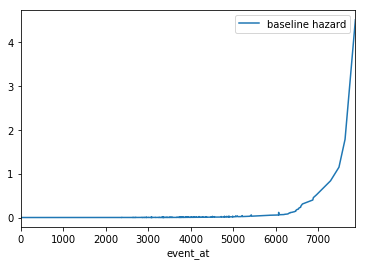

In [65]:
# cph.hazards_

# cph._log_likelihood

# cph._hessian_

cph._score_

cph2.baseline_hazard_.plot()